In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import cv2
import shutil
import PIL

from fastai import *
from fastai.vision import *

The drawings for this competition are described in csv files. We will go from the description to actual images on our hard drives - this will allow us to train using the familiar `ImageDataBunch.from_name_re`

If you are interested to learn more about the data format, you can find more information [here](https://www.kaggle.com/inversion/getting-started-viewing-quick-draw-doodles-etc). 

In [2]:
ls data/train | head

airplane.csv
alarm clock.csv
ambulance.csv
angel.csv
animal migration.csv
ant.csv
anvil.csv
apple.csv
arm.csv
asparagus.csv


Let's see how many images per class do we have. It takes a while to parse 7GB+ of csvs so I am running the code in parallel. If you are not familiar with this part of the Python API, do not worry!. This only speeds the code up a bit and there is rarely a genuine need to go this route.

**Please feel free to skip straight to the results.**

*(There is another way of getting the line count of a file that you can read about [here](https://stackoverflow.com/questions/845058/how-to-get-line-count-cheaply-in-python) - I am opting to parse the files as this will set up the stage for what I want to do later).*

In [3]:
%%time
def get_counts(path): return (path.stem, pd.read_csv(path).shape[0])
with ThreadPoolExecutor(32) as e: counts = list(e.map(get_counts, Path('data/train').iterdir()))

CPU times: user 5min 42s, sys: 1min 10s, total: 6min 53s
Wall time: 6min 42s


Oh my, this still took forever! Let's see what we got

In [4]:
sorted_counts = sorted(counts, key=lambda tup: tup[1])

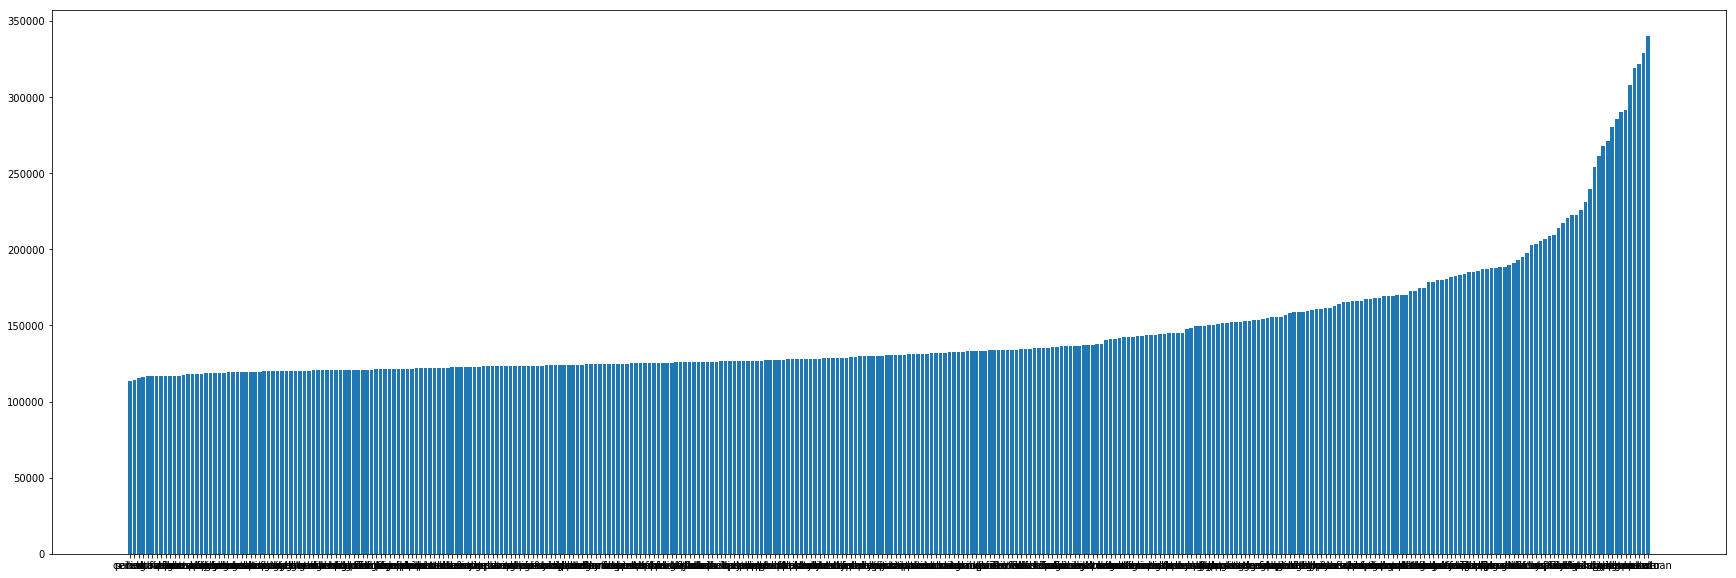

In [5]:
plt.bar([tup[0] for tup in sorted_counts], [tup[1] for tup in sorted_counts])
#plt.xticks(ticks=[], rotation='vertical');
fig = plt.gcf()
fig.set_size_inches(30, 10)

In [6]:
sorted_counts[:10]

[('panda', 113613),
 ('bed', 113862),
 ('ceiling fan', 115413),
 ('screwdriver', 116313),
 ('whale', 116502),
 ('stove', 116535),
 ('tractor', 116677),
 ('snowflake', 116685),
 ('leg', 116804),
 ('piano', 116870)]

In [7]:
sorted_counts[-10:]

[('cooler', 271444),
 ('yoga', 280442),
 ('harp', 285403),
 ('diving board', 290239),
 ('hand', 291773),
 ('banana', 307936),
 ('marker', 319136),
 ('calendar', 321981),
 ('potato', 329204),
 ('snowman', 340029)]

In [8]:
np.sum([tup[1] for tup in counts]), len(counts)

(49707579, 340)

We have 340 classes and a total of ~50 million drawings. The least represented class is a panda at 113 613 samples and the most represented class is a snowman with 340 039 samples. Assuming the quality of drawings does not vary much, this is not a class imbalance at all!

Maybe test images contain a similar class distribution? Having ~500k images seems like a nice place to start. Let's randomly pick 1% of images from each category and save them as jpg files.

But first, lets take a look at the data quickly.

In [9]:
df = pd.read_csv('data/train/snowman.csv')

In [10]:
df.head()

,countrycode,drawing,key_id,recognized,timestamp,word
0,SG,"[[[51, 37, 31, 33, 39, 56, 74, 88, 101, 106, 1...",5040959249186816,True,2017-03-19 13:09:20.410260,snowman
1,GB,"[[[128, 102, 73, 42, 36, 40, 55, 81, 112, 131,...",5057709479034880,True,2017-04-01 00:23:56.920640,snowman
2,US,"[[[95, 74, 56, 40, 36, 40, 53, 75, 89, 119, 13...",4649154502459392,True,2017-01-28 22:52:14.740020,snowman
3,US,"[[[17, 17], [36, 36]], [[14, 14, 26, 51, 58, 8...",5668944822140928,False,2017-03-02 19:02:04.755340,snowman
4,US,"[[[129, 116, 95, 79, 76, 79, 87, 111, 130, 139...",5670608501211136,True,2017-03-21 21:59:23.444070,snowman


In [11]:
# https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
BASE_SIZE = 256
def draw_cv2(raw_strokes, size=256, lw=5, time_color=False):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    img = cv2.copyMakeBorder(img,4,4,4,4,cv2.BORDER_CONSTANT)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    else:
        return img

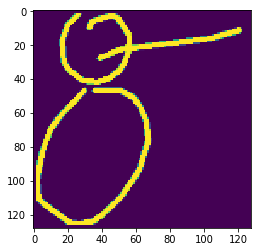

In [12]:
plt.imshow(draw_cv2(eval(df.loc[0, 'drawing']), size=128))

We know how to generate images, we have looked at the data. Time to write images to disk and start training!

In [21]:
sz = 180 # size
r = 0.5 # portion of images to keep, we want only 1% of total train data
shutil.rmtree(f'data/train-{sz}', ignore_errors=True) # deleting whatever we have saved earlier
os.makedirs(f'data/train-{sz}') # best to have where to save the images

In [22]:
df = pd.read_csv('data/train/airplane.csv')
df.shape[0]

151623

In [23]:
def save_ims_from_df(path):
    df = pd.read_csv(path)
    selected = df[df.recognized==True].sample(int(r * df.shape[0]))
    for row in selected.iterrows():
        idx, drawing, label = row[0], eval(row[1].drawing), '_'.join(row[1].word.split())
        ary = draw_cv2(drawing, size=128)
        rgb_ary = np.repeat(ary[:,:,None], 3, -1)
        PIL.Image.fromarray(rgb_ary).save(f'data/train-{sz}/{label}_{idx}.png')
    print("out")

In [ ]:
%%time
with ThreadPoolExecutor(32) as e: e.map(save_ims_from_df, Path('data/train').iterdir())

out
out


In [ ]:
#print(f'{label}_{idx}.png')

A couple of sanity checks

In [17]:
!ls data/train-{sz} -lhS | head -n 5

total 0


In [22]:
PIL.Image.open(f'data/train-{sz}/blackberry_71321.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/train-680/blackberry_71321.png'

Seems to have worked. We now need to generating the test set.

In [ ]:
df = pd.read_csv('data/test_simplified.csv')

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
shutil.rmtree(f'data/test-{sz}', ignore_errors=True)
os.makedirs(f'data/test-{sz}')

In [ ]:
def save_test_ims_from_df(path):
    df = pd.read_csv(path)
    for row in df.iterrows():
        key_id, drawing = row[1].key_id, eval(row[1].drawing)
        ary = draw_cv2(drawing, size=128)
        rgb_ary = np.repeat(ary[:,:,None], 3, -1)
        PIL.Image.fromarray(rgb_ary).save(f'data/test-{sz}/{key_id}.png')

In [ ]:
%time save_test_ims_from_df('data/test_simplified.csv')

In [ ]:
ls -lht data/test-128 | head -n 10

In [ ]:
PIL.Image.open('data/test-128/9999968529902445.png')